<h2 align = "center">Mod 4: Regularization & Early Stopping</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import latte
import latte.nn as nn
import latte.optim as optim
import latte.functional as F
import latte.utils.data as data

import lattevision as lv
import lattevision.datasets as dsets
import lattevision.transforms as T


In [2]:
mnist_root = '../data/mnist'
mnist_transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

mnist_train = dsets.MNIST(mnist_root, train=True, transform=mnist_transform)
mnist_test = dsets.MNIST(mnist_root, train=False, transform=mnist_transform)

val_len = len(mnist_train) // 10
train_len = len(mnist_train) - val_len
mnist_train, mnist_val = data.random_split(mnist_train, [train_len, val_len])

train_batch_size = 128
test_batch_size = 512

train_loader = data.DataLoader(mnist_train, batch_size=train_batch_size, shuffle=True)
val_loader = data.DataLoader(mnist_val, batch_size=train_batch_size, shuffle=False)
test_loader = data.DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False)


## 1. Regularization

In [3]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


toy_model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(toy_model.parameters(), lr=1e-3)


In [4]:
max_epochs = 5
train_losses = []
train_accuracies = []

for epoch in range(max_epochs):
    # Training
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_batchs = 0

    for ii, (data, target) in tqdm(enumerate(train_loader)):
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        target = latte.Tensor(target)

        # Forward pass
        optimizer.zero_grad()
        output = toy_model(data)

        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.data

        # Backward pass
        loss.backward()
        optimizer.step()

        # Compute accuracy
        accuracy = (output.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy += accuracy

        # Logging
        train_losses.append(loss.data)
        train_accuracies.append(accuracy)

    print(f'Epoch {epoch + 1}/{max_epochs}')
    print('Training')
    print(
        f'\tLoss: {(epoch_loss / epoch_batchs): .4f} \
        \tAccuracy: {(epoch_accuracy / epoch_batchs): .4f}'
    )

    # Validation
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_batchs = 0
    
    for data, target in val_loader:
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        target = latte.Tensor(target)

        output = toy_model(data)

        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.data

        # Compute accuracy
        accuracy = (output.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy += accuracy

    print('Validation')
    print(
        f'\tLoss: {(epoch_loss / epoch_batchs): .4f} \
        \tAccuracy: {(epoch_accuracy / epoch_batchs): .4f}'
    )


421it [00:06, 63.81it/s]


Epoch 1/5
Training
	Loss:  0.4054         	Accuracy:  0.8890
Validation
	Loss:  0.2232         	Accuracy:  0.9405


421it [00:06, 62.88it/s]


Epoch 2/5
Training
	Loss:  0.1986         	Accuracy:  0.9509
Validation
	Loss:  0.2229         	Accuracy:  0.9575


421it [00:06, 64.31it/s]


Epoch 3/5
Training
	Loss:  0.1823         	Accuracy:  0.9632
Validation
	Loss:  0.2322         	Accuracy:  0.9637


421it [00:06, 66.00it/s]


Epoch 4/5
Training
	Loss:  0.1966         	Accuracy:  0.9663
Validation
	Loss:  0.2434         	Accuracy:  0.9705


421it [00:06, 67.88it/s]


Epoch 5/5
Training
	Loss:  0.1956         	Accuracy:  0.9700
Validation
	Loss:  0.2667         	Accuracy:  0.9703


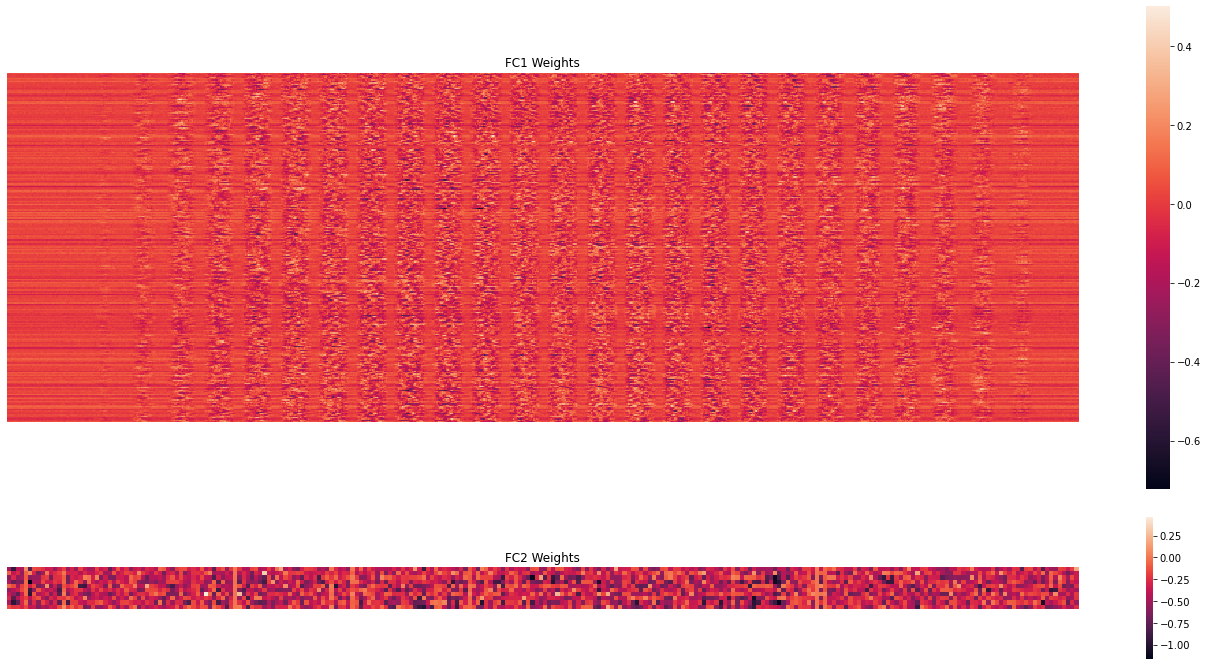

In [5]:
# Plot a heatmap of the weights

from matplotlib.gridspec import GridSpec

fc1_weights = toy_model.fc1.weight.data  # (784, 256)
fc2_weights = toy_model.fc2.weight.data  # (256, 10)

plt.figure(figsize=(24, 12))
gs = GridSpec(4, 1)

plt.subplot(gs[:3, :])
sns.heatmap(fc1_weights.T, cbar=True, square=True)
plt.title("FC1 Weights")
plt.axis('off')

plt.subplot(gs[-1:, :])
sns.heatmap(fc2_weights.T, cbar=True, square=True)
plt.title("FC2 Weights")
plt.axis('off')

plt.show()


## 2. Early Stopping

In [17]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [18]:
# Early stopping
trigger_times = 0
patience = 2

max_epochs = 10
train_losses = []
val_losses = [100]  # Initialize with a huge loss

for epoch in range(max_epochs):
    print(f'Epoch {epoch + 1}/{max_epochs}')

    # Training
    epoch_loss = 0
    epoch_batchs = 0

    for ii, (data, target) in enumerate(train_loader):
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        target = latte.Tensor(target)

        # Forward pass
        optimizer.zero_grad()
        output = model(data)

        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.data

        # Backward pass
        loss.backward()
        optimizer.step()

    # Logging
    train_losses.append(np.round(epoch_loss / epoch_batchs, 4))

    # Validation
    epoch_loss = 0
    epoch_batchs = 0
    
    for data, target in val_loader:
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        target = latte.Tensor(target)

        output = model(data)

        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.data

    # Logging
    val_losses.append(np.round(epoch_loss / epoch_batchs, 4))

    # Early stopping
    if val_losses[-1] > val_losses[-2]:
        trigger_times += 1
        if trigger_times == patience:
            print("Early Stopping!")
            print(f'\tTraining Losses: {train_losses}')
            print(f'\tValidation Losses: {val_losses[1:]}')
            break
    else:
        trigger_times = 0


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Early Stopping!
	Training Losses: [0.4003, 0.1986, 0.1909, 0.1975, 0.1778]
	Validation Losses: [0.225, 0.2484, 0.2384, 0.2474, 0.2908]


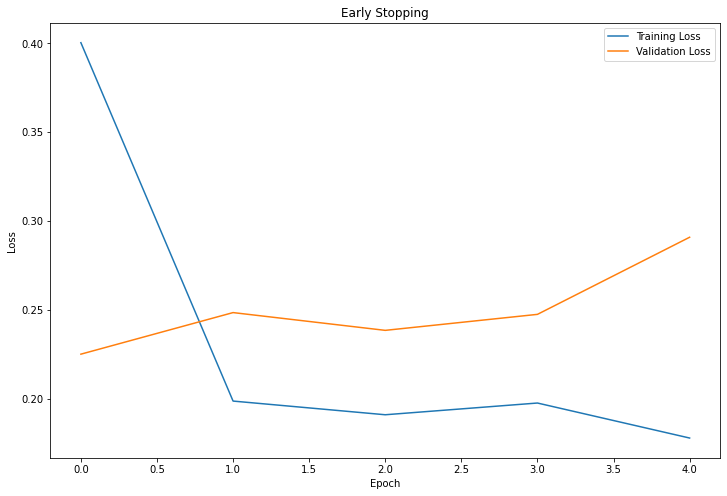

In [19]:
# Plot
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses[1:], label='Validation Loss')
plt.title("Early Stopping")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
# Test
correct = 0
total = 0
for data, target in test_loader:
    batch_size = data.shape[0]
    if batch_size != test_batch_size:
        continue

    data = latte.Tensor(data.reshape(batch_size, -1))
    target = latte.Tensor(target)

    output = model(data)
    correct += (output.data.argmax(axis=1) == target.data).sum()
    total += target.shape[0]

print(f'Accuracy: {correct / total: .4f}')


Accuracy:  0.9697
